# Predizione di dati clinici con dati RNA-Seq compressi

Sulla base dei dataset di dati molecolari relativi ai campioni prelevati dai pazienti, verranno costruiti dei classificatori che andranno a predire alcuni dati clinici / biologici dei pazienti affetti da tumore. Il primo step consiste nel creare un dataset contenente le label, ovvero i dati che il classificatore deve effettivamente predire. Nei dataset compressi è presente il codice del campione prelevato. Attraverso il dataset relativo ai campioni si può estrarre il codice di ogni paziente. Un ulteriore file servirà ad ottenere i dati clinici a partire dal paziente. Nella pratica, utilizzeremo la funzione fornita dal modulo ngs.

In [1]:
import pandas as pd 
import numpy  as np
import seaborn as sns
import matplotlib.pyplot as plt 

from modules import preprocess
from modules import ngs

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


Indichiamo le migliori compressioni in termini di loss:

In [2]:
blind_150_best = 'results/ngs/blind/loss_0.0080_150f_reduced_data_RNA_Seq_v2_mRNA_median_all_sample_ref_normal_Zscores.txt'
blind_50_best  = 'results/ngs/blind/loss_0.0083_50f_reduced_data_RNA_Seq_v2_mRNA_median_all_sample_ref_normal_Zscores.txt'
blind_25_best  = 'results/ngs/blind/loss_0.0087_25f_reduced_data_RNA_Seq_v2_mRNA_median_all_sample_ref_normal_Zscores.txt'
bias_150_best  = 'results/ngs/bias/accuracy_0.806_150f_reduced_data_RNA_Seq_v2_mRNA_median_all_sample_ref_normal_Zscores.txt'
bias_50_best   = 'results/ngs/bias/accuracy_0.806_50f_reduced_data_RNA_Seq_v2_mRNA_median_all_sample_ref_normal_Zscores.txt'
bias_25_best   = 'results/ngs/bias/accuracy_0.806_25f_reduced_data_RNA_Seq_v2_mRNA_median_all_sample_ref_normal_Zscores.txt'

Indichiamo quali dati vogliamo utilizzare per le predizioni:

In [3]:
use_biased_data = True

In [4]:
if (not use_biased_data):
    ds_f150_path = blind_150_best
    ds_f50_path  = blind_50_best
    ds_f25_path  = blind_25_best
else:
    ds_f150_path = bias_150_best
    ds_f50_path  = bias_50_best
    ds_f25_path  = bias_25_best
    
molecular_ds_150 = pd.read_csv(ds_f150_path, index_col=0)
molecular_ds_50  = pd.read_csv(ds_f50_path,  index_col=0)
molecular_ds_25  = pd.read_csv(ds_f25_path,  index_col=0)

Rimuoviamo le colonne costanti:

In [5]:
nc_molecular_ds_150 = preprocess.delete_constant_cols(molecular_ds_150)
nc_molecular_ds_50  = preprocess.delete_constant_cols(molecular_ds_50)
nc_molecular_ds_25  = preprocess.delete_constant_cols(molecular_ds_25)

## Descrizione dei dati clinici

Vogliamo predire in particolare i seguenti clinici: 
- SUBTYPE
- OS_MONTHS
- DSS_MONTHS
- DFS_MONTHS
- PFS_MONTHS

Definizioni dal *National Cancer Institute*: 

#### **OS - Overall Survival**
*The length of time from either the date of diagnosis or the start of treatment for a disease, such as cancer, that patients diagnosed with the disease are still alive. In a clinical trial, measuring the OS is one way to see how well a new treatment works. Also called overall survival.*

#### **DFS - Disease-Free Survival**
*In cancer, the length of time after primary treatment for a cancer ends that the patient survives without any signs or symptoms of that cancer. In a clinical trial, measuring the DFS is one way to see how well a new treatment works. Also called disease-free survival, relapse-free survival, and RFS.*

#### **PFS - Progression-Free Survival**
*The length of time during and after the treatment of a disease, such as cancer, that a patient lives with the disease but it does not get worse. In a clinical trial, measuring the PFS is one way to see how well a new treatment works. Also called progression-free survival.*

## Predizione del sottotipo

Inseriamo il rispettivo sottotipo in ogni record dei dataset compressi.

In [37]:
subtype_ds_150 = ngs.attach_label(molecular_ds_150, 'SUBTYPE')
subtype_ds_50  = ngs.attach_label(molecular_ds_50, 'SUBTYPE')
subtype_ds_25  = ngs.attach_label(molecular_ds_25, 'SUBTYPE')

Importiamo i classificatori da librerie esterne.

In [38]:
from modules.utilities import multilabel_train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

Confrontiamo i vari classificatori

In [39]:
datasets = [
    subtype_ds_150, 
    subtype_ds_50,
    subtype_ds_25
]

classifiers = [
    RandomForestClassifier(), 
    XGBClassifier(use_label_encoder=False), 
    SVC(kernel="linear", C=0.025)
]

classifiers_names = [
    'Random forest', 
    'XGBoost', 
    'Linear SVM'
]

Modificare i flag per ottenere una visualizzazione della matrice di confusione / salvarla.

In [40]:
visualize_confusion_matrix = True
save_confusion_matrix_plot = True

Otteniamo i risultati della classificazione

[13:59:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:59:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:59:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate 

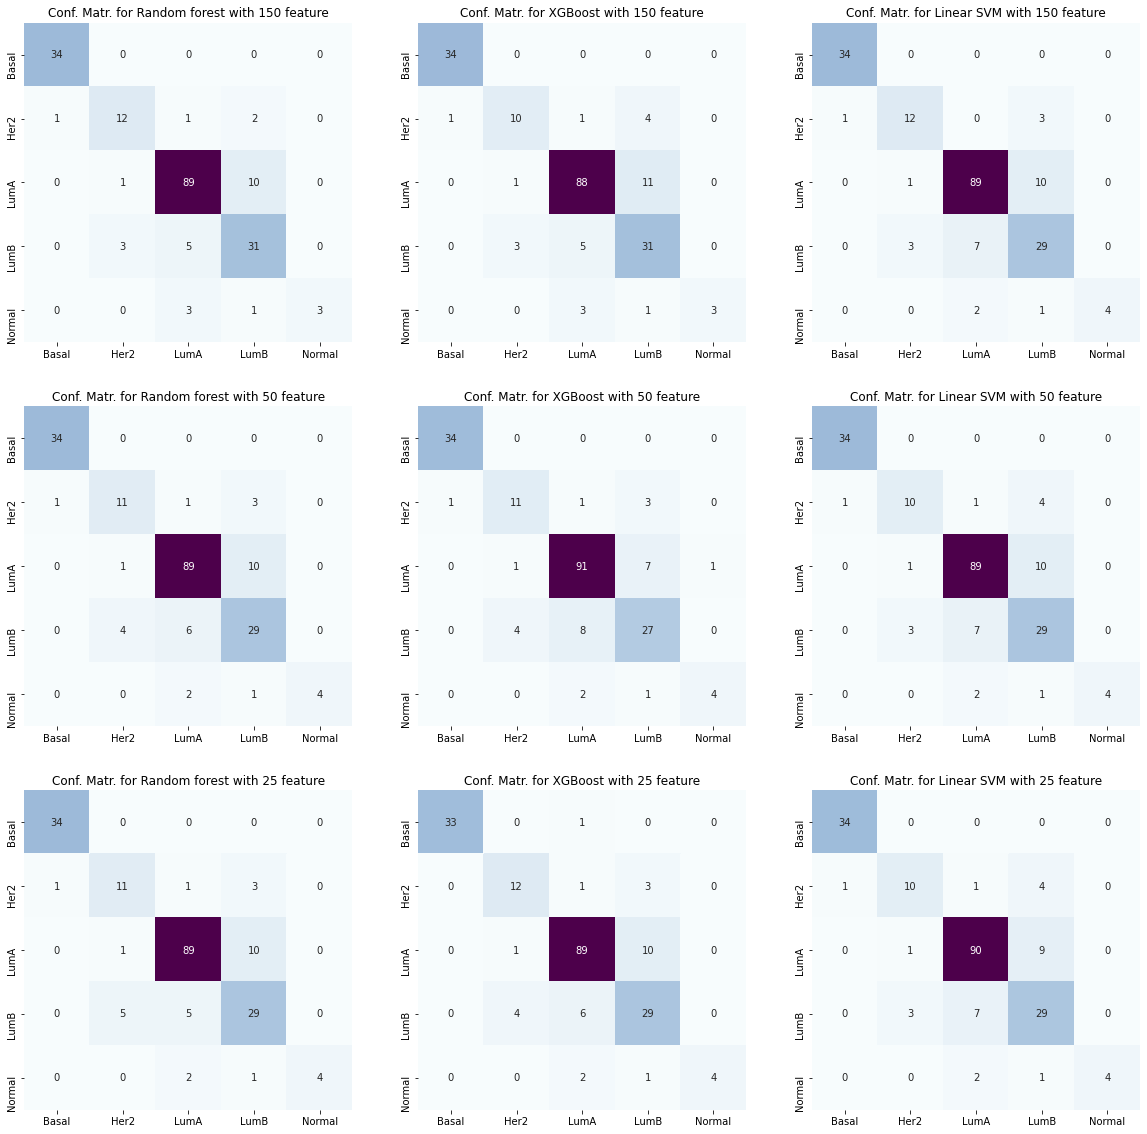

In [41]:
plt.figure(figsize=(20,20))

cols = 3
rows = 3
pidx = 1

for ds_counter, ds in enumerate(datasets):
    
    npoints, nfeatures = ds.shape
    # remove the label from the number of features 
    nfeatures -= 1
    train_set, valid_set =  multilabel_train_test_split(ds, 'SUBTYPE', .2)
    train_set, test_set  =  multilabel_train_test_split(train_set, 'SUBTYPE', .2)
    
    label_encoder = LabelEncoder()
    label_encoder.fit(train_set['SUBTYPE'].unique())
    
    if (visualize_confusion_matrix):
        # extract the labels to visualize those into the heatmap
        labels = label_encoder.inverse_transform(range(5))
        labels = [ label.split('_')[1] for label in labels ]
    
    takex = lambda ds: ds.drop(['SUBTYPE'], axis=1)
    takey = lambda ds: label_encoder.transform(ds['SUBTYPE'])
    x_train, x_test, x_valid = takex(train_set), takex(test_set), takex(valid_set) 
    y_train, y_test, y_valid = takey(train_set), takey(test_set), takey(valid_set)
    
    if (not visualize_confusion_matrix):
        print(('-' * 15) + f'{nfeatures} features' + ('-' * 15))
    
    for name, model in zip(classifiers_names, classifiers):
        
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        y_pred_val = model.predict(x_valid)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_micro = f1_score(y_test, y_pred, average='micro')
        fi_weigh = f1_score(y_test, y_pred, average='weighted')

        val_accuracy = accuracy_score(y_valid, y_pred_val)
        val_f1_macro = f1_score(y_valid, y_pred_val, average='macro')
        val_f1_micro = f1_score(y_valid, y_pred_val, average='micro')
        val_f1_weigh = f1_score(y_valid, y_pred_val, average='weighted')
        cmatrix = confusion_matrix(y_valid,y_pred_val)
        
        if (not visualize_confusion_matrix):
            print(f'{name} got:')
            print(f"\t accuracy:    {accuracy} \t val. accuracy:    {val_accuracy}")
            print(f"\t F1 macro:    {f1_macro} \t val. F1 macro:    {val_f1_macro}")
            print(f"\t F1 micro:    {f1_micro} \t val. F1 micro:    {val_f1_micro}")
            print(f"\t F1 weighted: {fi_weigh} \t val. F1 weighted  {val_f1_weigh}")
            print("Confusion matrix on validation data:")
            print(cmatrix)
            print("\n")
        else:
            plt.subplot(rows, cols, pidx)
            title = plt.title(f'Conf. Matr. for {name} with {nfeatures} feature')
            # plt.setp(title, color='yellow')
            plt.setp(title, color='black')
            sns.heatmap(cmatrix, 
                        xticklabels=labels, 
                        yticklabels=labels, 
                        annot=True, cbar=False,
                        cmap='BuPu')
            pidx += 1

if (visualize_confusion_matrix and save_confusion_matrix_plot):
    figname = 'plots/confusion_matrix_rna_seq'
    figname += '_biased.png' if use_biased_data else '.png'           
    plt.savefig(figname , dpi=150, transparent=False)        

## Predizione della survival

In [7]:
def attach_all_survivals(ds):
    ds = ngs.attach_label(ds, 'OS_MONTHS')
    ds = ngs.attach_label(ds, 'DSS_MONTHS')
    ds = ngs.attach_label(ds, 'DFS_MONTHS')
    ds = ngs.attach_label(ds, 'PFS_MONTHS')
    return ds

def round_all_survivals(ds):
    ds['OS_MONTHS']  = ds['OS_MONTHS'].round()
    ds['DSS_MONTHS'] = ds['DSS_MONTHS'].round()
    ds['DFS_MONTHS'] = ds['DFS_MONTHS'].round()
    ds['PFS_MONTHS'] = ds['PFS_MONTHS'].round()
    return ds

df150 = round_all_survivals(attach_all_survivals(molecular_ds_150))
df50 = round_all_survivals(attach_all_survivals(molecular_ds_50))
df25 = round_all_survivals(attach_all_survivals(molecular_ds_25))

### Analisi della covarianza

Per ogni variabile da predire (survival) calcoliamo la covarianza tra la variabile e le feature molecolari. Dopodiché prendiamo le 3 feature che, in valore assoluto, presentano covarianza maggiore. Visualizziamo uno scatterplot che rappresenti la disposizione delle feature rispetto alla variabile. 

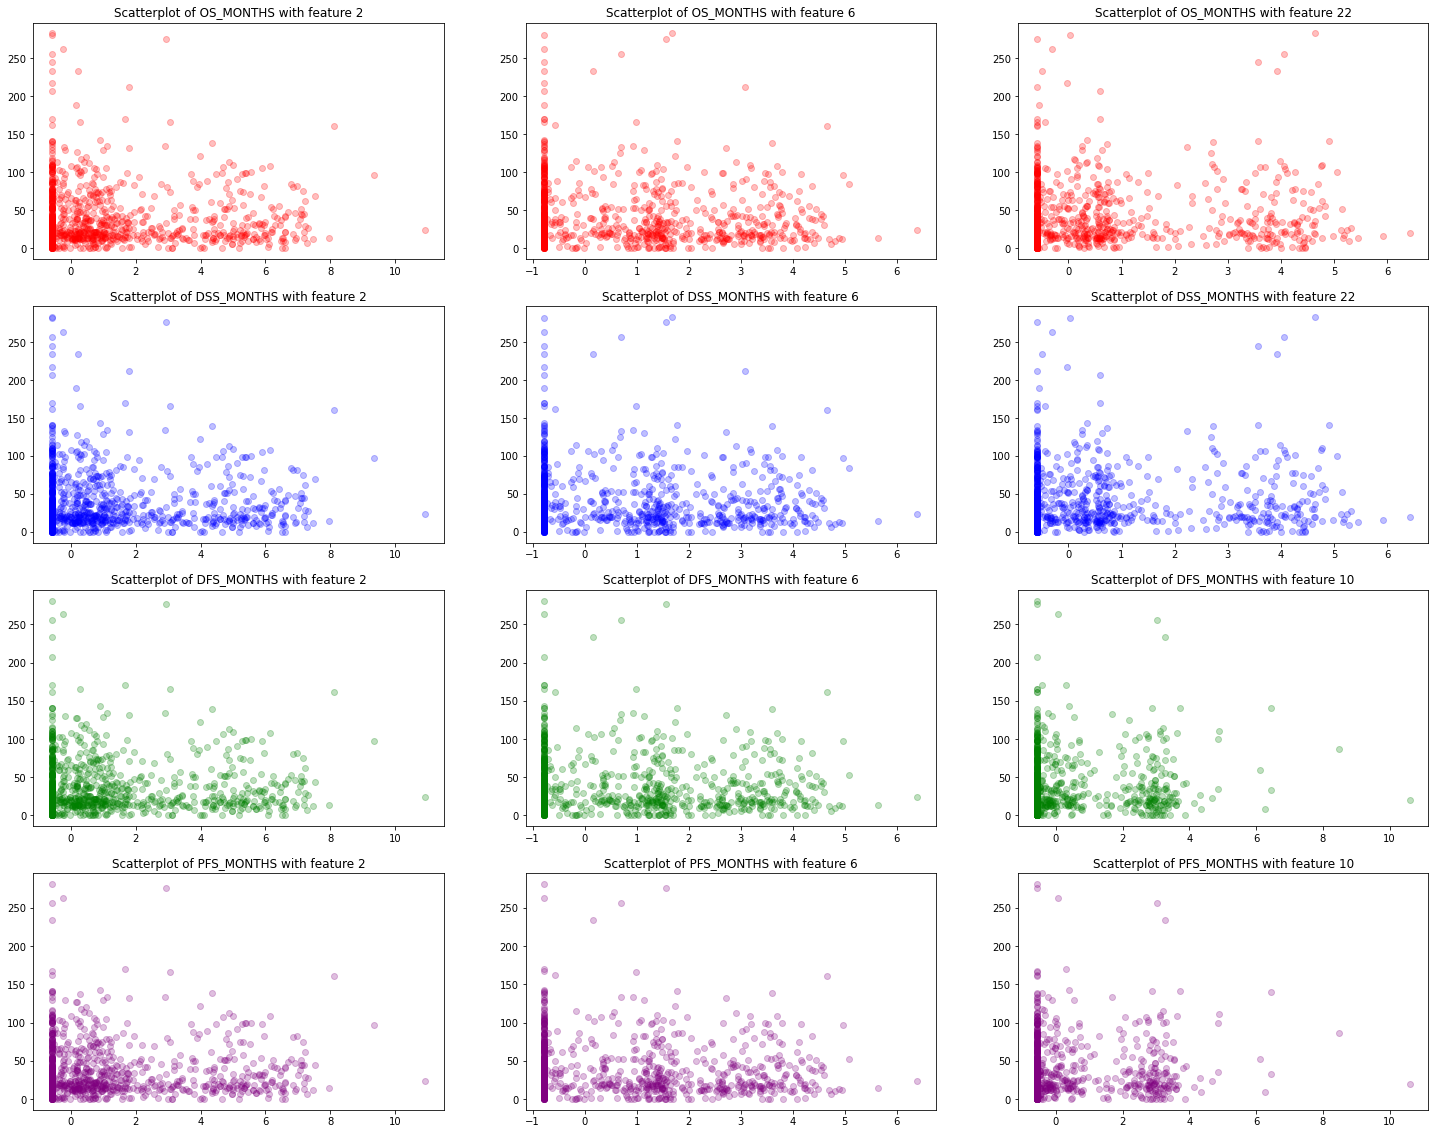

In [8]:
from math import ceil

plt.figure(figsize=(25,20))

variables = [
    'OS_MONTHS', 
    'DSS_MONTHS', 
    'DFS_MONTHS',
    'PFS_MONTHS'
]

colors = {
    'OS_MONTHS':  'red', 
    'DSS_MONTHS': 'blue', 
    'DFS_MONTHS': 'green',
    'PFS_MONTHS': 'purple'
}

df25_features = df25.drop(variables, 1)

cols = 3
rows = 4
pidx = 1

for variable in variables:
    # compute the covariance matrix 
    cov_mat = pd.concat([ df25_features, df25[variable]], axis=1).cov()
    # take the first 3 biggest value of covariance (in absolute value)
    # and exclude the variable itself 
    feature_podium = cov_mat[variable].abs().nlargest(4)[1:4]
    # iterate through the most correlated features and do a scatterplot 
    for feature_index, covariance in feature_podium.items(): 
        plt.subplot(rows, cols, pidx)
        plt.scatter(df25[feature_index], df25[variable], color=colors.get(variable), alpha=0.25)
        title = plt.title(f'Scatterplot of {variable} with feature {feature_index}')
        plt.setp(title, color='black')
        pidx += 1

### Matrice di correlazione

[ 0.02547839 -0.02873701 -0.0538173  -0.05069206  0.01043189  0.04362899
 -0.05297763  0.00206172  0.01318698 -0.00634336  0.05418684 -0.00159549
 -0.02548133  0.01204782  0.02694756 -0.03594621  0.00819024  0.01116649
  0.04970843  0.0293637   0.02201179  0.03507514  0.05050402  0.02372902
  0.01376499]


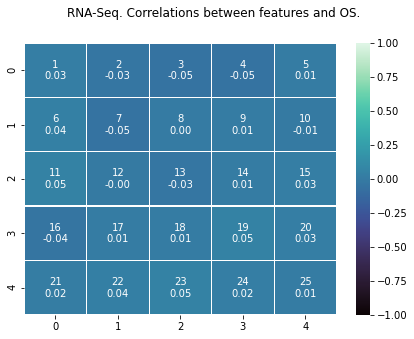

In [9]:
C = df25.corr()
vtodrop  = ['OS_MONTHS', 'DSS_MONTHS', 'DFS_MONTHS', 'PFS_MONTHS']
cv = C['OS_MONTHS'].drop(vtodrop).values
pad = 25 - len(cv)
print(cv)
cell_format = lambda f, v: f"{f}\n{v:.2f}"

txt = np.concatenate((np.arange(1, len(cv) + 1), np.full(pad, -1)))
val = np.concatenate((cv, np.zeros(pad, dtype=cv.dtype)))
ann = (np.asarray([ cell_format(f, v) for f, v in zip(txt, val)]))

txt = txt.reshape(5, 5)
val = val.reshape(5, 5)
ann = ann.reshape(5, 5)

fig = plt.figure(figsize = (7, 5))
plt.suptitle('RNA-Seq. Correlations between features and OS.')
sns.heatmap(val, linewidths=.3, annot=ann, cmap="mako", fmt="", vmin=-1, vmax=1)
plt.show()

### Valutazione dei modelli

In [ ]:
from IPython.display import display
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

regressors = [
    linear_model.LinearRegression(), 
    linear_model.Ridge(alpha=.2), 
    linear_model.Lasso(alpha=0.1, max_iter=10000), 
    linear_model.LassoLars(alpha=.1), 
    linear_model.BayesianRidge(), 
    ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=5), 
    ensemble.RandomForestRegressor(n_estimators=100, max_depth=30)
]

regressors_names = [
    'Linear regression', 
    'Ridge regression', 
    'Lasso', 
    'Lasso-Lars', 
    'Bayesian Ridge', 
    'Gradient Boosting', 
    'Random Forest'
]

datasets = [df150, df50, df25]

for variable in variables: 
    regr_scores = {name: [] for name in regressors_names}
    for ds_counter, ds in enumerate(datasets):

        X = ds.drop(variables, 1)
        y = ds[variable]
    
        for name, estimator in zip(regressors_names, regressors):
            
            kfold   = KFold(n_splits=10)
            results = cross_val_score(estimator, X, y, cv=kfold, scoring='neg_mean_absolute_error') 
            regr_scores.get(name).append(round(results.mean(), 2))
    
    print(f"Negative mean absolute error on variable {variable}")
    scores = pd.DataFrame(regr_scores)
    scores.index = (['150f', '50f', '25f'])
    display(scores)